In [ ]:
###############################
#Script for creating plots of showing pathway coverages of VAE models vs DeepProfile
###############################

from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
    


/homes/gws/abdincer/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cancer_types = ['BRCA', 'AML', 
                'COLON', 'LUNG', 
                'BRAIN', 'OV', 
                'SARCOMA', 'KIDNEY', 
                'LIVER', 'STOMACH', 
                'SKIN', 'PROSTATE',
                'THYROID', 'UTERINE', 
                'HEAD_NECK', 'PANCREAS',
                'CERVICAL', 'BLADDER']

cancer_names = ['BREAST', 'AML',
                'COLORECTAL', 'LUNG',
                'BRAIN', 'OV', 
                'SARCOMA', 'KIDNEY', 
                'LIVER', 'STOMACH', 
                'MELANOMA', 'PROSTATE',
                'THYROID', 'UTERINE', 
                'HEAD&NECK', 'PANCREAS',
                'CERVICAL', 'BLADDER']

cancer_colors = ['#f19066', #BREAST = SAWTOOTH TANK
                 '#778beb', #AML = SOFT BLUE
                '#3dc1d3', #COLON = BLUE CHORACO
                 '#303952', #LUNG = BISCAY
                '#786fa6', #BRAIN = PURPLE MOUNTAIN
                 '#c44569', #OV = DEEP ROSE
                '#e77f67', #SARCOMA = BREWED MUSTARD
                 '#596275', #KIDNEY = PENCIL LEAD
                '#f5cd79', #LIVER = SUMMER TIME
                 '#546de5', #STOMACH = CORN FLOWER
                '#e15f41', #MELANOMA = TIGERLY
                 '#f7d794', #PROSTATE = ROSY HIGHLIGHT
                '#e66767', #THYROID = PORCELAIN ROSE
                 '#574b90', #UTERINE = PURPLE CORALLITE
                '#cf6a87', #HEADNECK = OLD GRENIUM
                 '#f3a683', #PANCREAS = CREAMY PEACH
                '#63cdda',  #CERVICAL = SQUEAKY
                 '#f8a5c2'] #BLADDER = ROGUE PINK


In [10]:
#Define method for creating plot
def createPlot(cancer_type, threshold = 100):
    
    input_folder = '../../ALL_CANCER_FILES/' + cancer_type + '/PATHWAY_FILES/'

    #Also read pathway matrix
    pathway_df = pd.read_table(input_folder + 'PATHWAY_C2_MATRIX_INTERSECTION_GENES.tsv', index_col = 0)
    pathway_matrix = pathway_df.values
    print("Pathway matrix ", pathway_df.shape)

    #Read DeepProfile pathway coverages
    DP_df = pd.read_table(input_folder + cancer_type + 
                          '_FISHER_FDR_CORRECTED_PVALS_C2_DeepProfile_1.tsv', index_col = 0)
    print("P-values matrix ", DP_df.shape)

    #Read VAE model pathway coverages
    dims = [5, 10, 25, 50, 75, 100]
    VAE_pvals_list = []
    for dim in dims:
        for i in range(100):
            vae_df = pd.read_table(input_folder + cancer_type + '_FISHER_FDR_CORRECTED_PVALS_C2_VAE_' 
                                   + str(dim) + 'L_' + str(i + 1) + '.tsv', index_col = 0)
            VAE_pvals_list.append(vae_df.values)

    #Now create a binary matrix which shows the p-vals for significant
    binary_matrix = np.zeros((600 + 1, pathway_df.shape[1])) #Last dimension in DeepProfile

    for i in range(binary_matrix.shape[0] - 1):
        indices = np.where( VAE_pvals_list[i] < 0.05)[1]
        binary_matrix[i, indices] = 1

    indices = np.where(DP_df.values < 0.05)[1]
    binary_matrix[600, indices] = 1

    #Now for each dimension we want to detect the pathways 
    #covered by at least half of the models
    vals_5L = np.mean( binary_matrix[:100, :], axis = 0)
    vals_5L = vals_5L > 0.5

    vals_10L = np.mean( binary_matrix[100:200, :], axis = 0)
    vals_10L = vals_10L > 0.5

    vals_25L = np.mean( binary_matrix[200:300, :], axis = 0)
    vals_25L = vals_25L > 0.5

    vals_50L = np.mean( binary_matrix[300:400, :], axis = 0)
    vals_50L = vals_50L > 0.5

    vals_75L = np.mean( binary_matrix[400:500, :], axis = 0)
    vals_75L = vals_75L > 0.5

    vals_100L = np.mean( binary_matrix[500:600, :], axis = 0)
    vals_100L = vals_100L > 0.5

    #Join matrices and make non-zero indices
    joined_matrix = np.row_stack([vals_5L, vals_10L, vals_25L, vals_50L, vals_75L, vals_100L, binary_matrix[600, :]])
    DeepProfile_matrix = joined_matrix[-1, :]
    #print("Joined matrix ", joined_matrix.shape)
    summary_matrix = joined_matrix[:6, :]
    summary_matrix = np.sum(summary_matrix, axis = 0)

    thresholds = [1, 2, 3, 4, 5, 6]
    percents_for_thresholds = []
    counts_for_VAEs = []
    counts_for_DeepProfile = []

    for threshold in thresholds:
        #print("Threshold ", threshold)
        VAE_indices = np.where(summary_matrix >= threshold)[0]
        DeepProfile_indices = np.where(DeepProfile_matrix == 1)[0]
        #print(VAE_indices)
        #print(DeepProfile_indices)
        common_indices = np.intersect1d(VAE_indices, DeepProfile_indices)
        #print(common_indices)
        #print(len(common_indices))

        #print("No of pathways captured by VAEs ", len(VAE_indices))
        #print("No of pathways captured by DeepProfile as well ", len(common_indices))
        final_ratio = (len(common_indices) / len(VAE_indices)) * 100
        #print("FINAL RATIO ", final_ratio)
        percents_for_thresholds.append(final_ratio)
        counts_for_DeepProfile.append(len(common_indices))
        counts_for_VAEs.append(len(VAE_indices))

    print("All final results ")
    print(percents_for_thresholds)

    #Create plot
    mpl.rcParams['axes.linewidth'] = 5

    fig, ax = plt.subplots()
    fig.set_size_inches(17, 10)

    SMALL_SIZE = 30
    MEDIUM_SIZE = 50
    BIGGER_SIZE = 80

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    c = np.where(np.asarray(cancer_types) == cancer_type)[0][0]
    ax.bar(np.arange(len(thresholds)), counts_for_VAEs, 
            width = 0.35, alpha= 0.8, color = '#808080')
    ax.bar(np.arange(len(thresholds)) + 0.4, counts_for_DeepProfile, 
            width = 0.35, alpha= 0.8, color = cancer_colors[c])
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    #ax.set_yticklabels([])
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


Pathway matrix  (7592, 1077)
P-values matrix  (150, 1077)
All final results 
[79.34782608695652, 88.43537414965986, 92.0, 97.0873786407767, 100.0, 100.0]


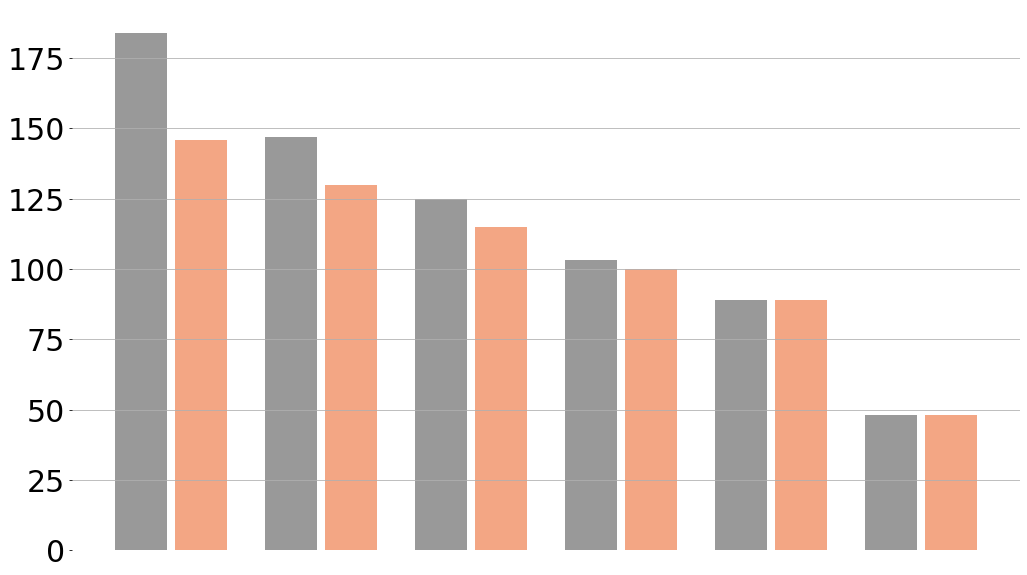

Pathway matrix  (11579, 1077)
P-values matrix  (150, 1077)
All final results 
[20.179372197309416, 23.93617021276596, 27.95031055900621, 29.655172413793103, 26.31578947368421, 21.62162162162162]


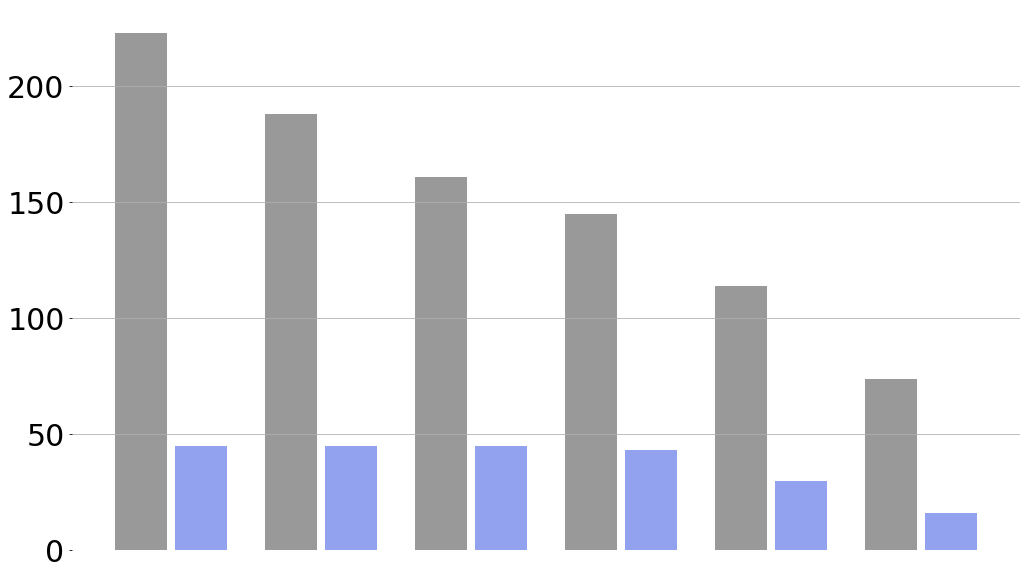

Pathway matrix  (10030, 1077)
P-values matrix  (150, 1077)
All final results 
[58.92857142857143, 67.02127659574468, 74.50980392156863, 79.36507936507937, 100.0, 100.0]


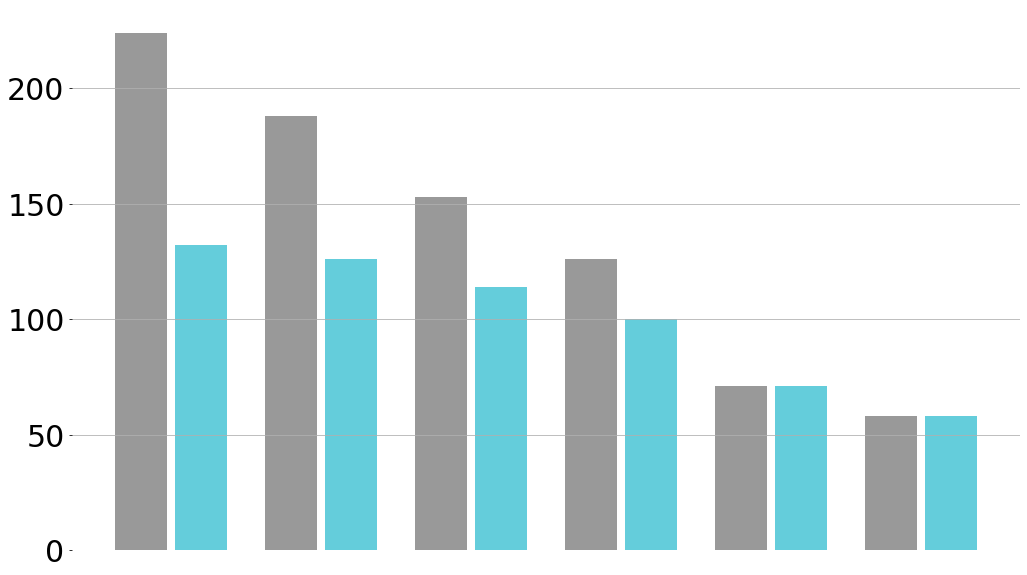

Pathway matrix  (10551, 1077)
P-values matrix  (150, 1077)
All final results 
[76.28865979381443, 86.875, 89.36170212765957, 91.72932330827066, 94.05940594059405, 98.52941176470588]


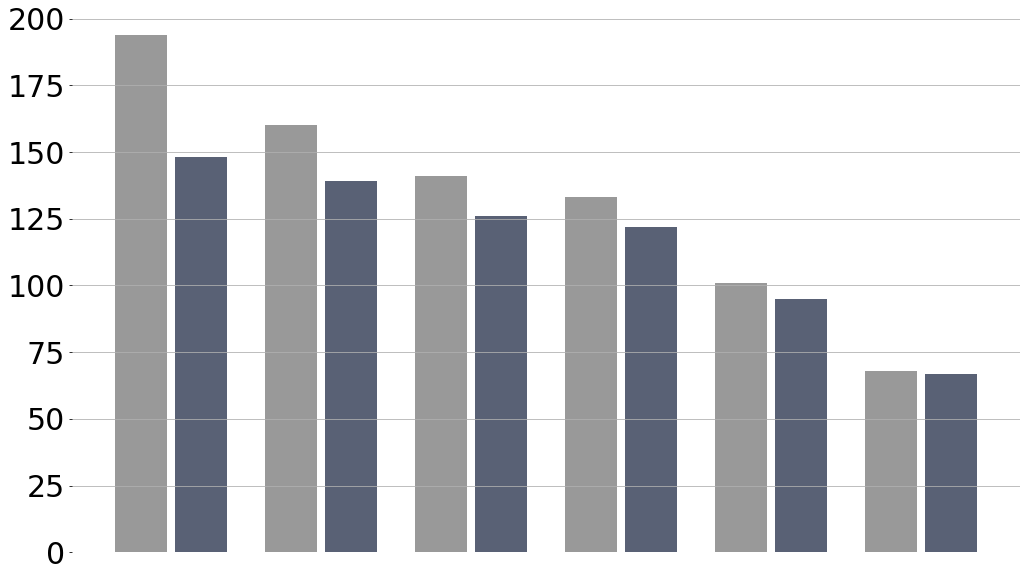

Pathway matrix  (7656, 1077)
P-values matrix  (150, 1077)
All final results 
[76.40449438202246, 90.9090909090909, 92.06349206349206, 92.5925925925926, 86.95652173913044, 100.0]


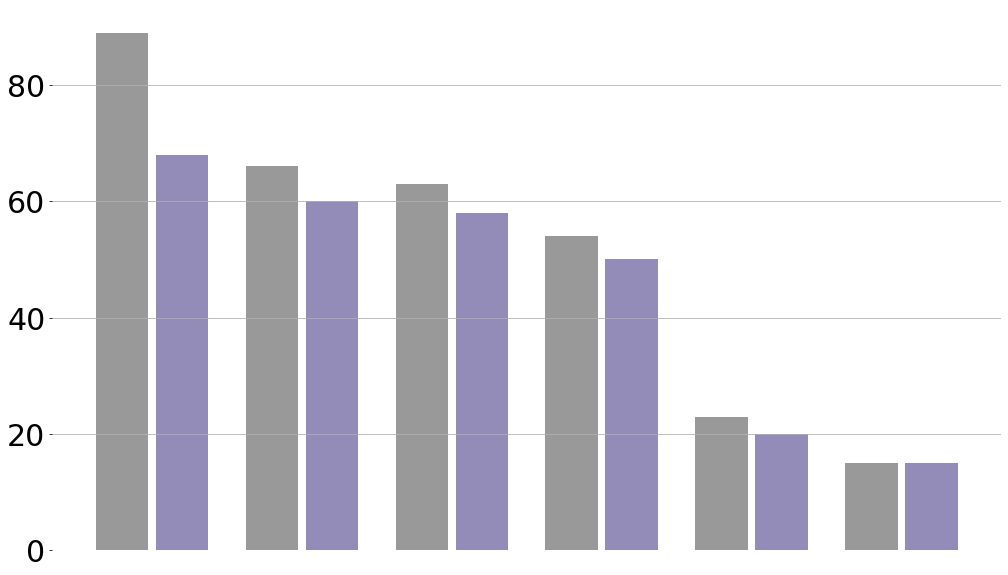

Pathway matrix  (10342, 1077)
P-values matrix  (150, 1077)
All final results 
[83.92857142857143, 88.31168831168831, 94.24460431654677, 96.21212121212122, 96.46017699115043, 98.75]


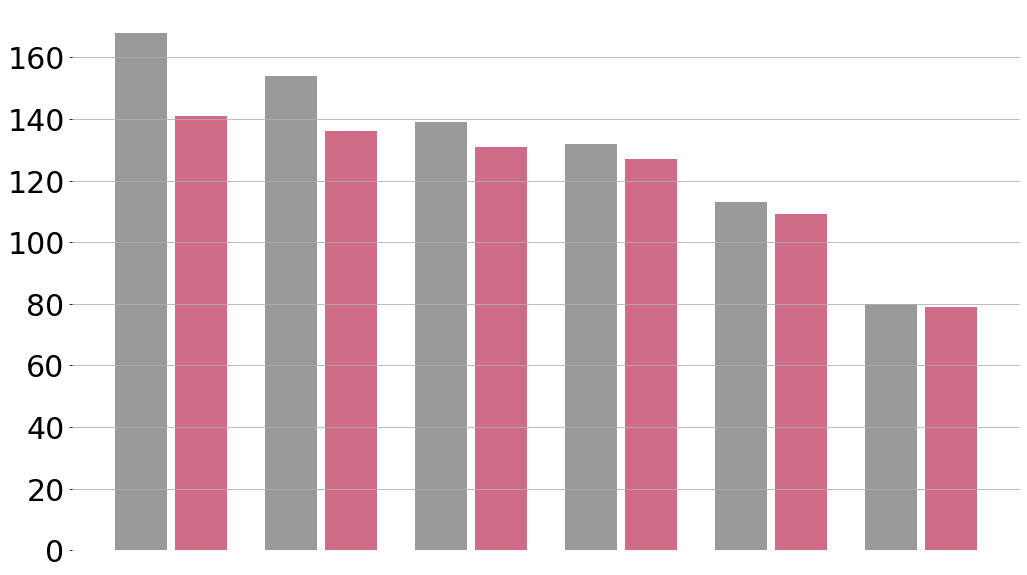

Pathway matrix  (9916, 1077)
P-values matrix  (150, 1077)
All final results 
[68.0672268907563, 71.83098591549296, 76.68393782383419, 87.01298701298701, 98.0392156862745, 100.0]


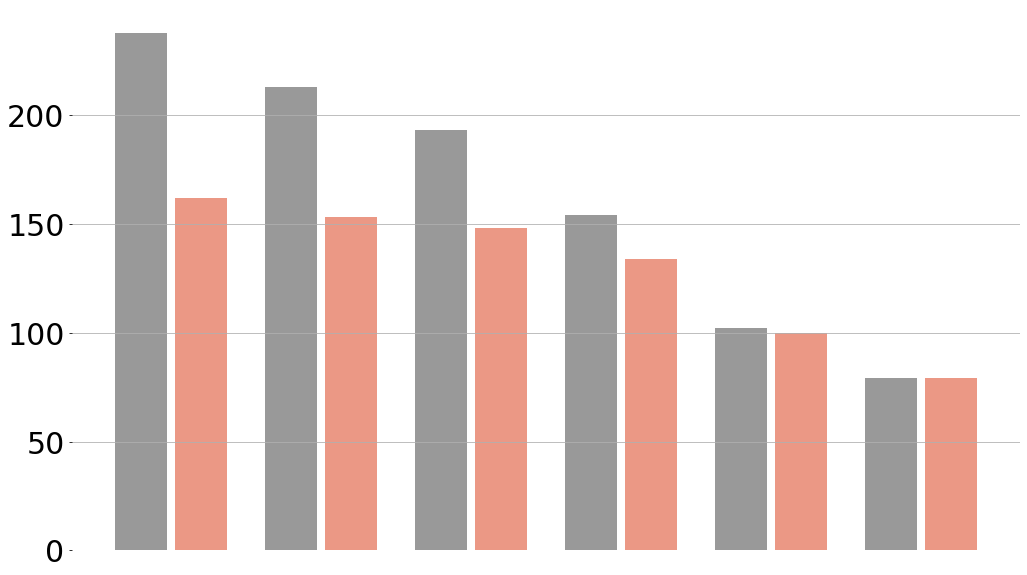

Pathway matrix  (12730, 1077)
P-values matrix  (150, 1077)
All final results 
[86.08247422680412, 90.22988505747126, 91.9753086419753, 94.66666666666667, 99.13793103448276, 100.0]


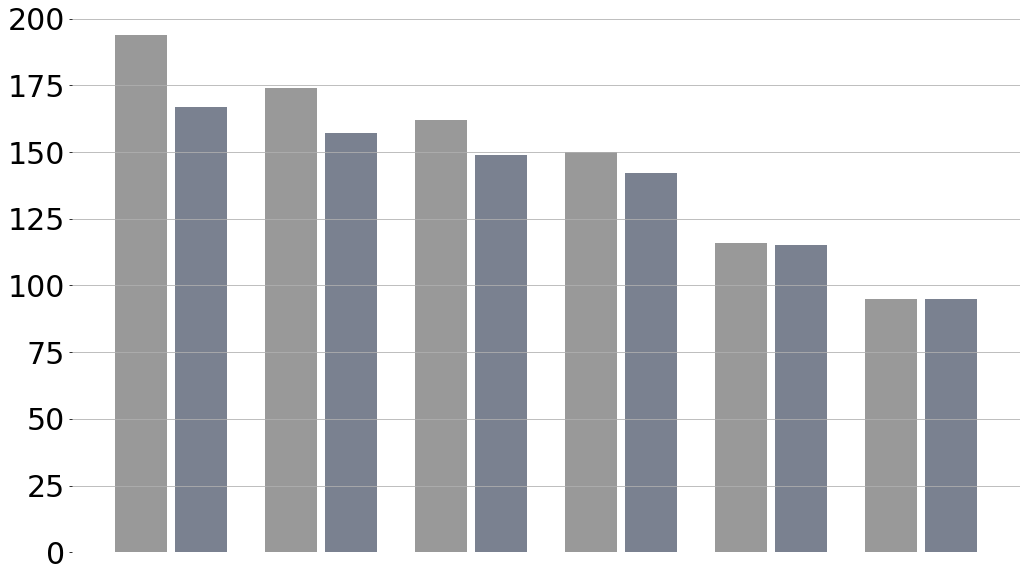

Pathway matrix  (13236, 1077)
P-values matrix  (150, 1077)
All final results 
[86.70212765957447, 91.41104294478528, 94.92753623188406, 98.1981981981982, 100.0, 100.0]


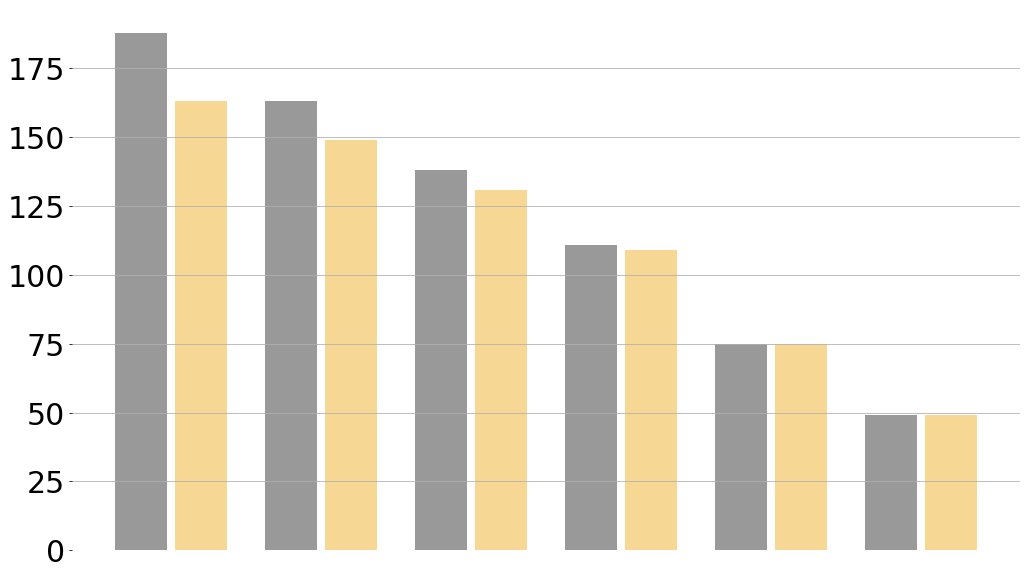

Pathway matrix  (12641, 1077)
P-values matrix  (150, 1077)
All final results 
[79.45945945945945, 84.33734939759037, 86.09271523178808, 91.91176470588235, 93.26923076923077, 98.36065573770492]


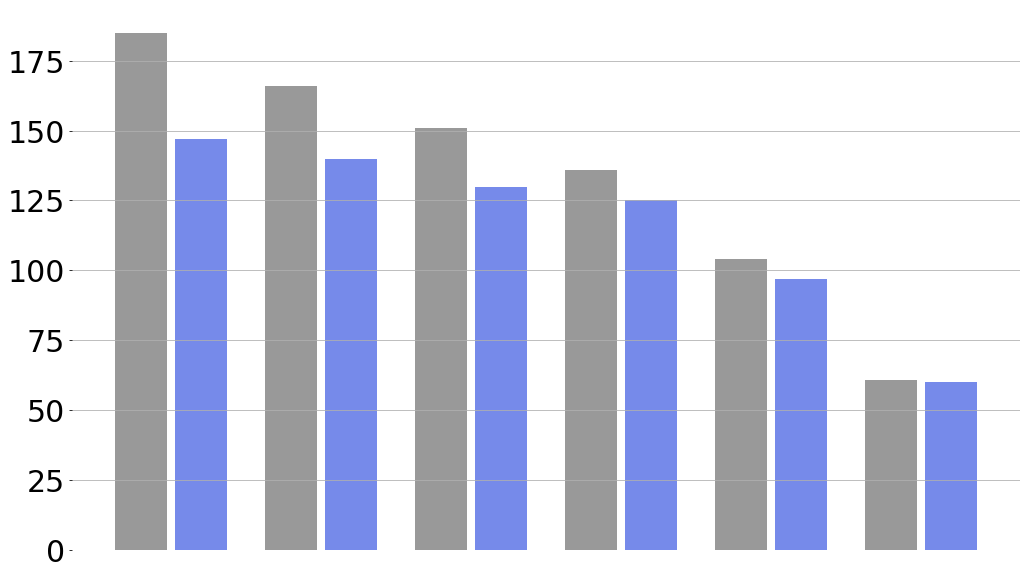

Pathway matrix  (12339, 1077)
P-values matrix  (150, 1077)
All final results 
[85.48387096774194, 91.01796407185628, 94.5578231292517, 99.23664122137404, 98.94736842105263, 100.0]


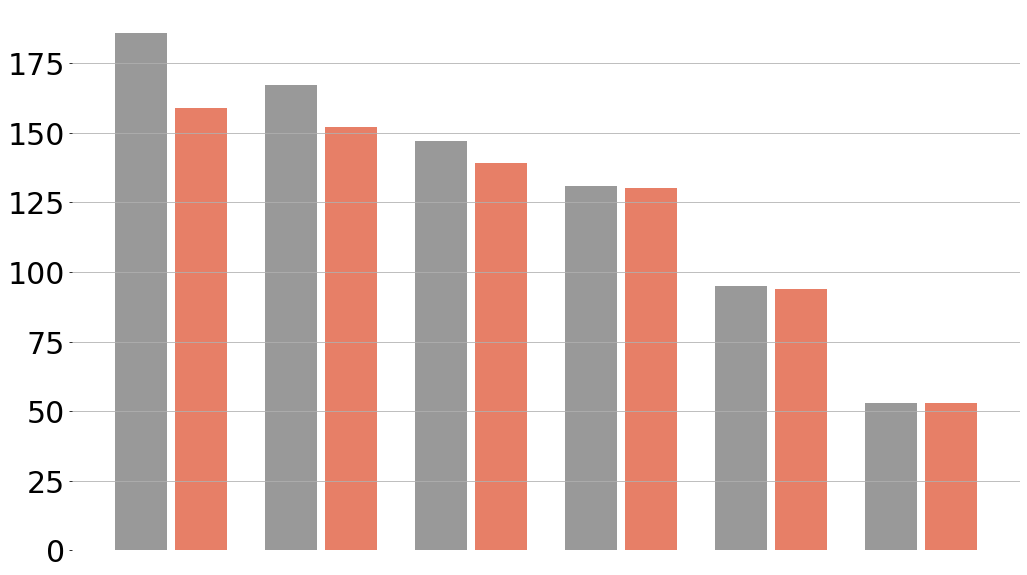

Pathway matrix  (11646, 1077)
P-values matrix  (150, 1077)
All final results 
[61.935483870967744, 66.41221374045801, 71.55172413793103, 78.88888888888889, 94.11764705882352, 100.0]


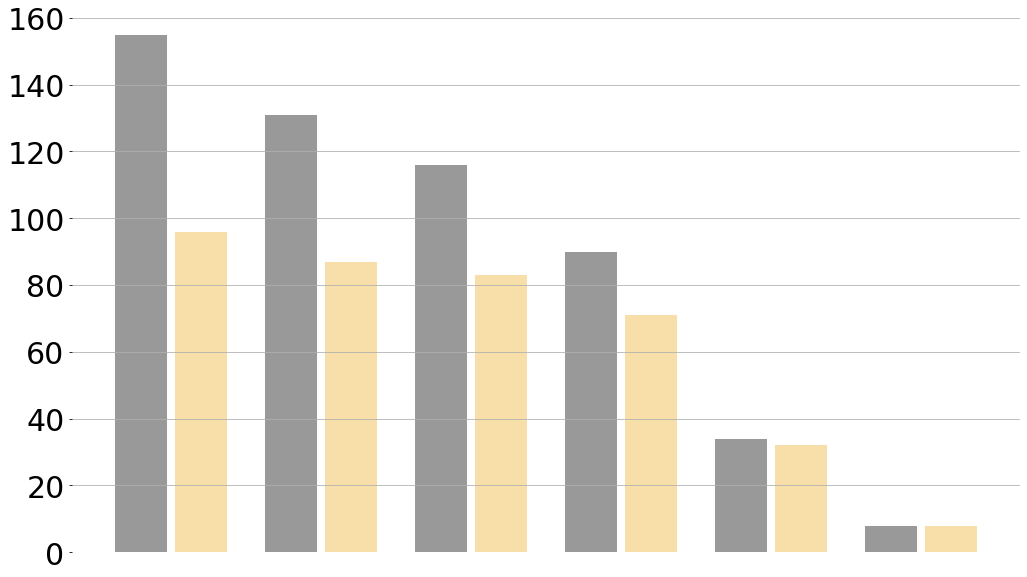

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[70.86092715231787, 76.61290322580645, 84.15841584158416, 89.1891891891892, 91.66666666666666, 100.0]


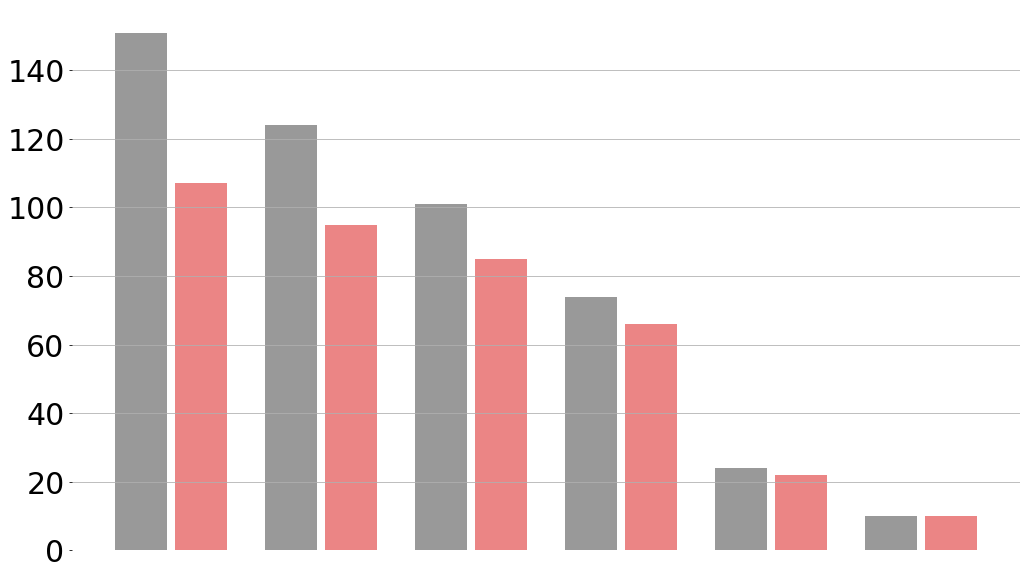

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[85.71428571428571, 90.12345679012346, 94.63087248322147, 97.79411764705883, 98.24561403508771, 100.0]


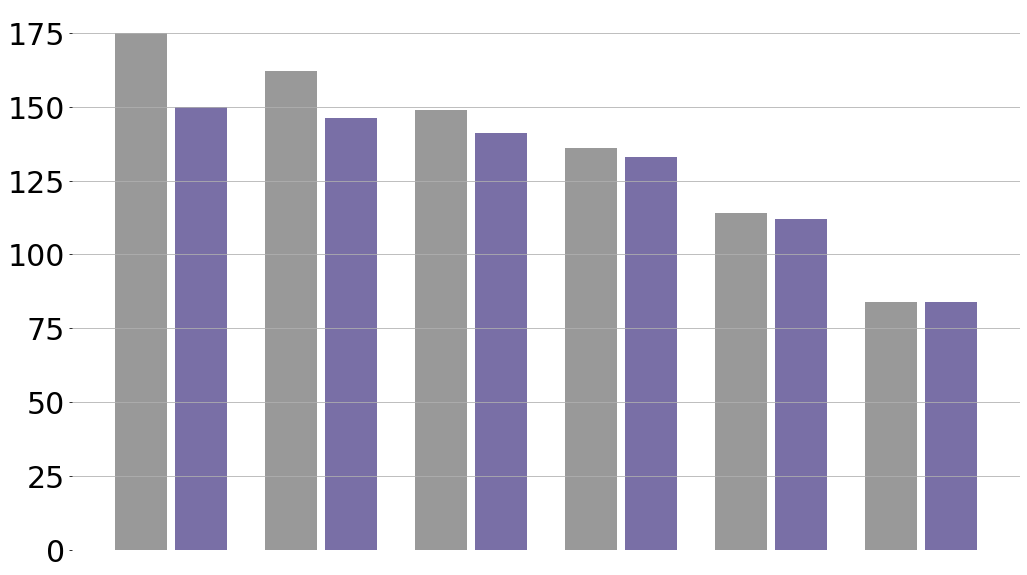

Pathway matrix  (11020, 1077)
P-values matrix  (150, 1077)
All final results 
[84.93723849372385, 91.86602870813397, 93.26424870466322, 95.97701149425288, 99.28571428571429, 100.0]


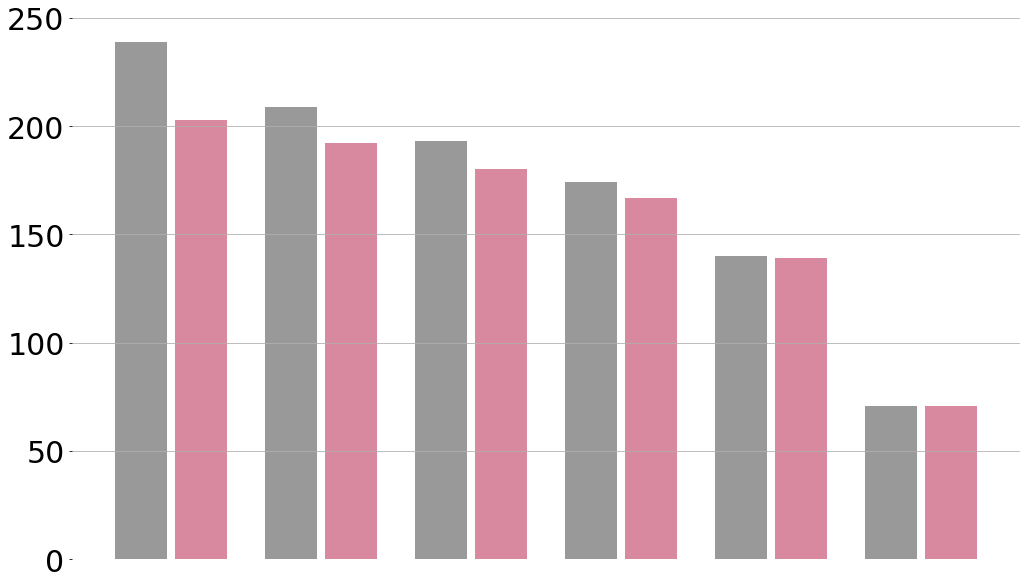

Pathway matrix  (4610, 1077)
P-values matrix  (150, 1077)
All final results 
[85.71428571428571, 93.96551724137932, 96.96969696969697, 97.82608695652173, 98.71794871794873, 98.24561403508771]


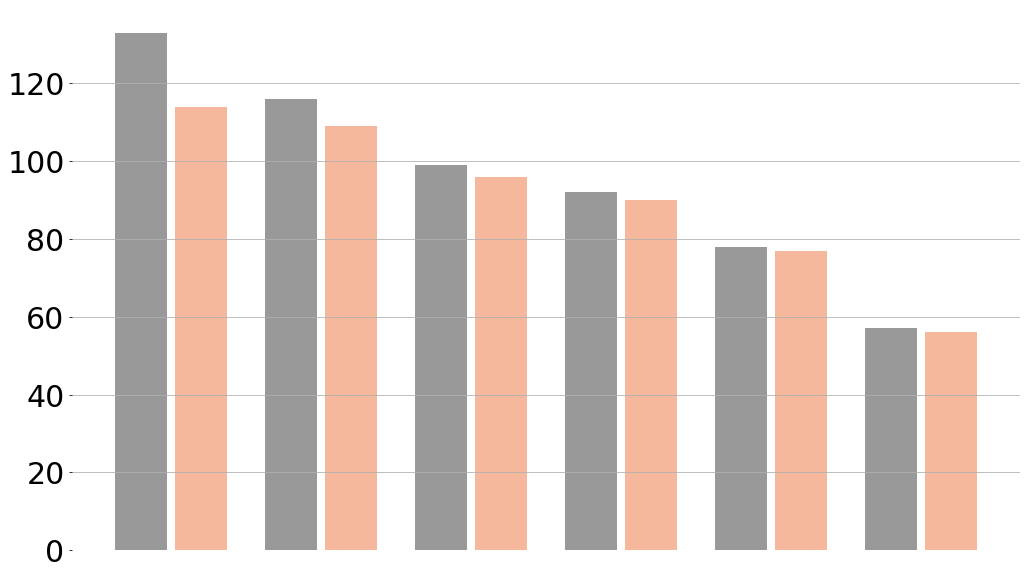

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[77.31958762886599, 87.24832214765101, 88.97058823529412, 93.38842975206612, 96.15384615384616, 100.0]


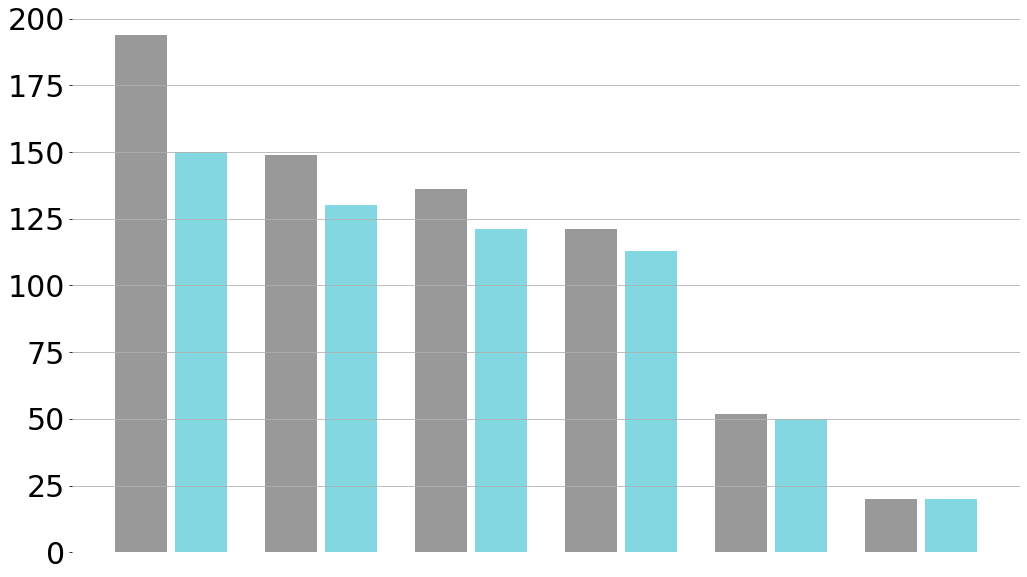

Pathway matrix  (13237, 1077)
P-values matrix  (150, 1077)
All final results 
[82.00836820083683, 87.67123287671232, 91.2621359223301, 96.80851063829788, 98.57142857142858, 100.0]


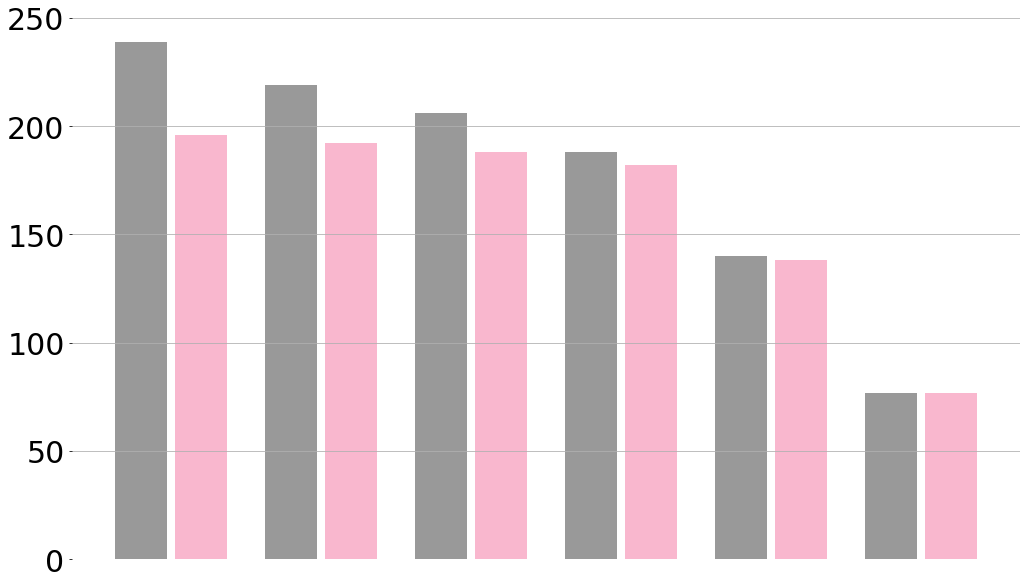

In [11]:
for cancer in cancer_types:
    createPlot(cancer)